<h1 style="font-family:Comic Sans MS; text-align: center">Welcome to my image classification notebook</h1>

<img style="margin: 0 auto" src='https://th.bing.com/th/id/R.8db5efdbe3f36746b18f7779c04b2d58?rik=cI6mHINHQQkjGg&pid=ImgRaw&r=0'>

<span style="font-family:Comic Sans MS; font-size: 20px">👋 Hi everyone, I’ve developed an image classification model that categorizes marine animals into 20 classes using the MobileNetV2 pretrained model. This project was a practice exercise to reinforce the fundamentals of convolutional neural networks (CNNs) and to get more familiar with TensorFlow and Keras APIs. I’d appreciate any feedback—thanks! 🙏 </span>

# Install And Import Essential Libreries

In [1]:
!pip install imutils

  Preparing metadata (setup.py) ... - \ done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=04af7ea24abcadaf57fab67a5a22ed3cd9959fa67a67a6b9221e5eacb49e3390
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imutils import paths
import random
import itertools
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix

2024-08-12 16:51:22.064766: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 16:51:22.064896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 16:51:22.188929: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  1


# Define Necessary Functions

In [4]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=75)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [5]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"], label="train_acc")
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.title("Training Loss And Accuracy")
    plt.ylabel("Loss/Accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.show()

# Get Data

In [6]:
# Get Train Images
imagePaths = list(paths.list_images('/kaggle/input/marine-animals-dataset/train'))
labels = list(map(lambda imagePath: imagePath.split(os.path.sep)[-2], imagePaths))

imagePaths = pd.Series(imagePaths, name='imagePath').astype(str)
labels = pd.Series(labels, name='Label')

train_df = pd.concat([imagePaths, labels], axis=1)
train_df.head()

,imagePath,Label
0,/kaggle/input/marine-animals-dataset/train/Sea...,Sea Turtle
1,/kaggle/input/marine-animals-dataset/train/Sea...,Sea Turtle
2,/kaggle/input/marine-animals-dataset/train/Sea...,Sea Turtle
3,/kaggle/input/marine-animals-dataset/train/Sea...,Sea Turtle
4,/kaggle/input/marine-animals-dataset/train/Sea...,Sea Turtle


In [7]:
# Get Test Images
imagePaths = list(paths.list_images('/kaggle/input/marine-animals-dataset/test'))
labels = list(map(lambda imagePath: imagePath.split(os.path.sep)[-2], imagePaths))

imagePaths = pd.Series(imagePaths, name='imagePath').astype(str)
labels = pd.Series(labels, name='Label')

test_df = pd.concat([imagePaths, labels], axis=1)
test_df.head()

,imagePath,Label
0,/kaggle/input/marine-animals-dataset/test/Sea ...,Sea Turtle
1,/kaggle/input/marine-animals-dataset/test/Sea ...,Sea Turtle
2,/kaggle/input/marine-animals-dataset/test/Sea ...,Sea Turtle
3,/kaggle/input/marine-animals-dataset/test/Sea ...,Sea Turtle
4,/kaggle/input/marine-animals-dataset/test/Sea ...,Sea Turtle


In [8]:
# Get Valid Images
imagePaths = list(paths.list_images('/kaggle/input/marine-animals-dataset/valid'))
labels = list(map(lambda imagePath: imagePath.split(os.path.sep)[-2], imagePaths))

imagePaths = pd.Series(imagePaths, name='imagePath').astype(str)
labels = pd.Series(labels, name='Label')

valid_df = pd.concat([imagePaths, labels], axis=1)
valid_df.head()

,imagePath,Label
0,/kaggle/input/marine-animals-dataset/valid/Sea...,Sea Turtle
1,/kaggle/input/marine-animals-dataset/valid/Sea...,Sea Turtle
2,/kaggle/input/marine-animals-dataset/valid/Sea...,Sea Turtle
3,/kaggle/input/marine-animals-dataset/valid/Sea...,Sea Turtle
4,/kaggle/input/marine-animals-dataset/valid/Sea...,Sea Turtle


# Explore Data

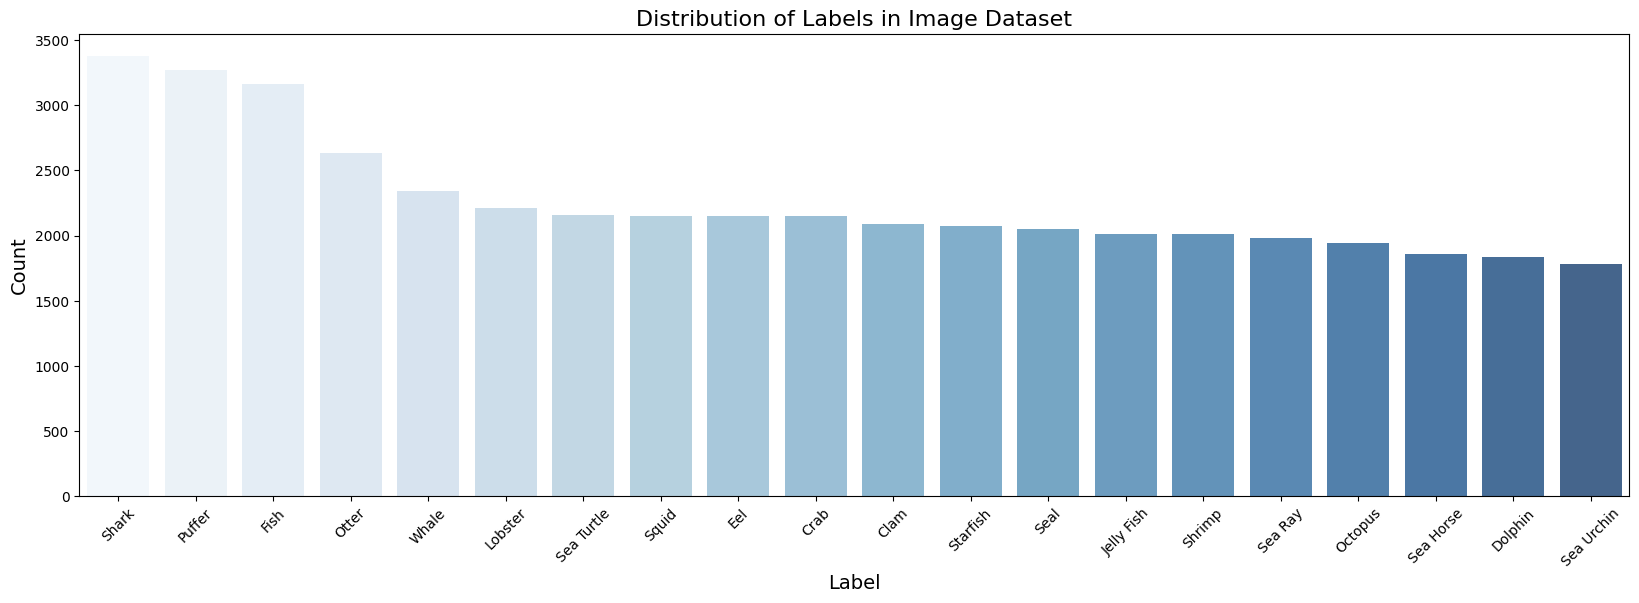

In [9]:
label_counts = train_df['Label'].value_counts()

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='Blues')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45) 
plt.show()

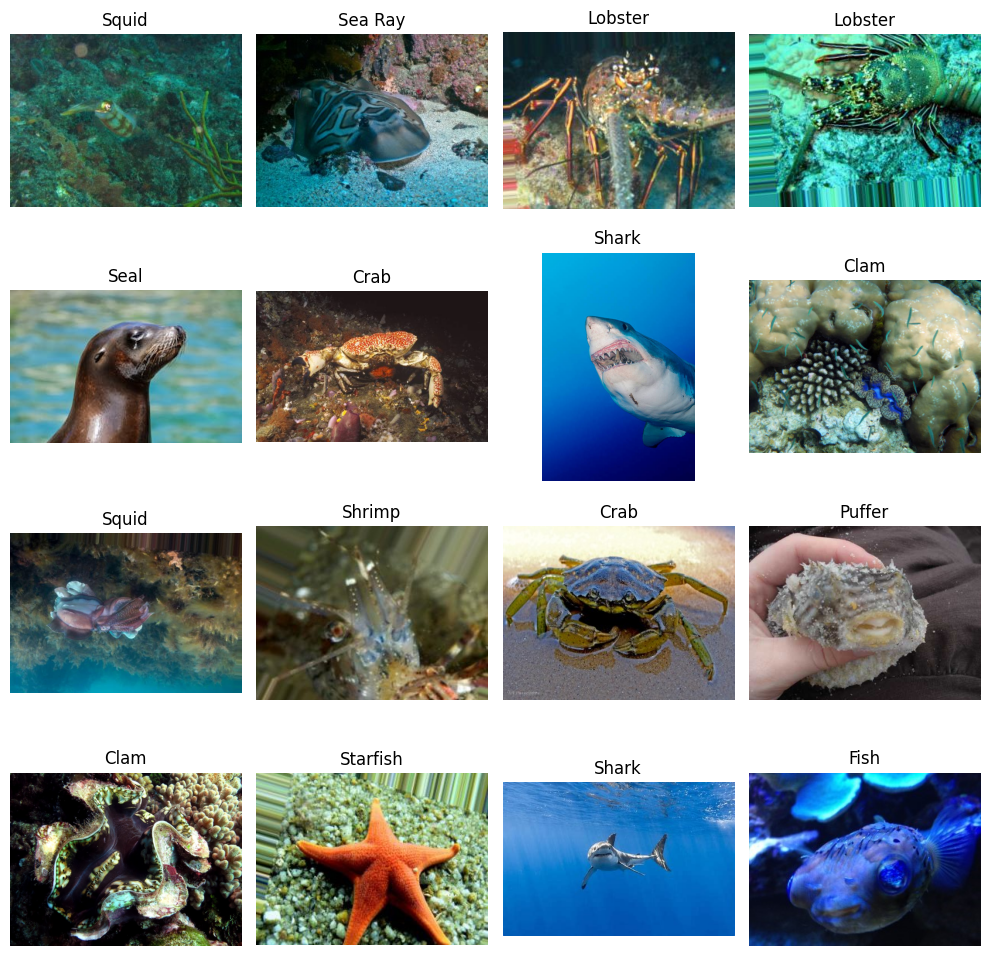

In [10]:
random_index = np.random.randint(0, len(train_df), 20)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i, ax in zip(np.arange(0, 20), axes.flatten()):
    ax.imshow(plt.imread(train_df.imagePath[random_index[i]]))
    ax.set_title(train_df.Label[random_index[i]])
    ax.axis('off')
plt.tight_layout()

In [11]:
generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
train_batches = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imagePath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64
)

test_batches = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imagePath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

valid_batches = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imagePath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64
)

Found 45246 validated image filenames belonging to 20 classes.
Found 399 validated image filenames belonging to 20 classes.
Found 1000 validated image filenames belonging to 20 classes.


# Build Model

In [13]:
mobile = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
augment = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomBrightness(0.1),
    layers.GaussianNoise(0.1)
])

In [15]:
inputs = mobile.input
x = augment(inputs)

x = Dense(units=728, activation='relu')(mobile.output)
x = Dropout(0.5)(x)
x = Dense(units=1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(units=20, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)

In [16]:
for layer in model.layers[:-34]:
    layer.trainable = False

In [17]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,957,548 (15.10 MB)

 Trainable params: 3,072,044 (11.72 MB)

 Non-trainable params: 885,504 (3.38 MB)

# Train Model

In [18]:
checkpoint_callback = ModelCheckpoint("checkpoint_model.weights.h5", 
                                      save_weights_only=True, 
                                      monitor="val_accuracy", 
                                      save_best_only=True,
                                      verbose=0
                                     )

early_stopping = EarlyStopping(monitor = "val_accuracy",
                               patience = 5,
                               mode= "min",
                               restore_best_weights = True
                              )

In [19]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/707 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - accuracy: 0.0664 - loss: 3.3714   

I0000 00:00:1723481604.247777      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


198/707 ━━━━━━━━━━━━━━━━━━━━ 5:48 684ms/step - accuracy: 0.2968 - loss: 2.4247

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


707/707 ━━━━━━━━━━━━━━━━━━━━ 533s 714ms/step - accuracy: 0.5277 - loss: 1.6083 - val_accuracy: 0.8420 - val_loss: 0.5492
Epoch 2/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 214s 299ms/step - accuracy: 0.8604 - loss: 0.4635 - val_accuracy: 0.8810 - val_loss: 0.4277
Epoch 3/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 211s 296ms/step - accuracy: 0.9171 - loss: 0.2727 - val_accuracy: 0.9090 - val_loss: 0.4038
Epoch 4/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 213s 299ms/step - accuracy: 0.9506 - loss: 0.1661 - val_accuracy: 0.9040 - val_loss: 0.3917
Epoch 5/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 211s 296ms/step - accuracy: 0.9669 - loss: 0.1075 - val_accuracy: 0.9070 - val_loss: 0.4066
Epoch 6/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 218s 305ms/step - accuracy: 0.9771 - loss: 0.0741 - val_accuracy: 0.9100 - val_loss: 0.4482


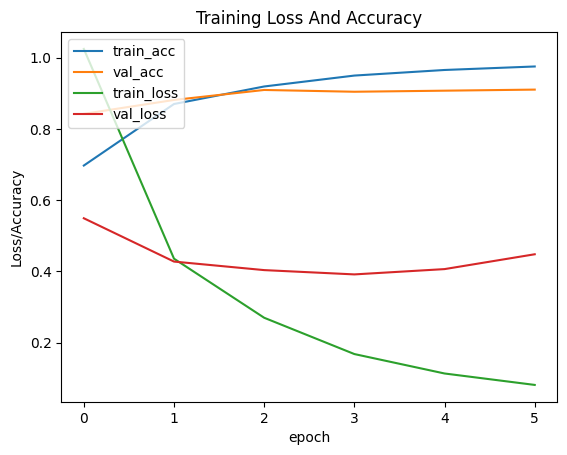

In [20]:
H = model.fit(x=train_batches, 
              validation_data=valid_batches, 
              callbacks=[early_stopping, checkpoint_callback], 
              epochs=10)
plot_hist(H)

# Evaluate Model

In [21]:
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

Confusion matrix, without normalization


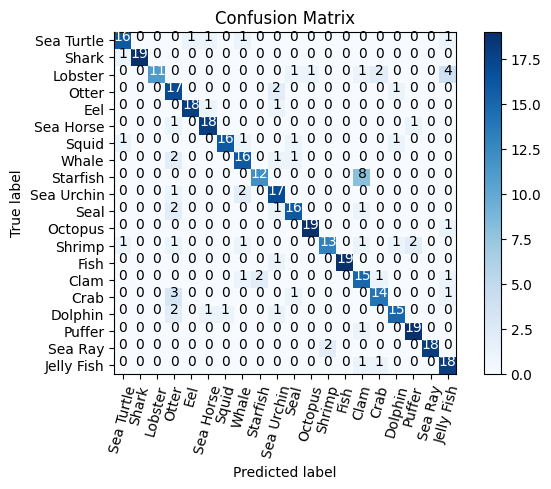

In [22]:
cm_plot_labels = ["Sea Turtle", 'Shark', 'Lobster', 'Otter', 'Eel', 'Sea Horse', 'Squid', 'Whale', 'Starfish', 'Sea Urchin', 'Seal', 'Octopus', 'Shrimp', 'Fish', 'Clam', 'Crab', 'Dolphin', 'Puffer', 'Sea Ray', 'Jelly Fish']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Save Model

In [23]:
model.save("Sea_Animals_Model.h5")